In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist.data, mnist.target

In [2]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:] 
#mnist dataset 내부에서 자체적으로 이미 test, train set을 나누어 놓아서 이렇게 해도 ok. 원래는 train_test_split 사용

### 3-2. 이진 분류

#### 5를 감지하는 이진 분류기 만들기

In [3]:
y_train_5 = (y_train == '5') #train set 내에서 5이면 True, 5가 아니면 False 반환하는 벡터. 
y_test_5 = (y_test == '5')

In [4]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42) 
sgd_clf.fit(X_train, y_train_5) #이진 분류기이기 때문에 y_train_5로 써주기

SGDClassifier(random_state=42)

In [5]:
sgd_clf.predict(X[0:1])

array([ True])

In [6]:
y[0:1]

0    5
Name: class, dtype: category
Categories (10, object): ['0', '1', '2', '3', ..., '6', '7', '8', '9']

분류기가 5를 정확하게 맞췄다.

#### 이진 분류기의 성능 측정

##### 교차검증

In [7]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [8]:
from sklearn.base import BaseEstimator
import numpy as np

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X),1), dtype=bool)
    

never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

In [9]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [29]:
from sklearn.metrics import confusion_matrix #오차행렬
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [10]:
from sklearn.metrics import precision_score, recall_score #정밀도와 재현율
precision_score(y_train_5, y_train_pred) 

0.8370879772350012

In [11]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [12]:
from sklearn.metrics import f1_score #f1 score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [13]:
y_scores = sgd_clf.decision_function(X[0:1]) #decision_function 메서드를 통해 각 샘플의 score
y_scores #출력

array([2164.22030239])

In [15]:
threshold=0
y_some_digit_pred = (y_scores>threshold)

In [16]:
y_some_digit_pred

array([ True])

In [18]:
threshold=9000
y_some_digit_pred = (y_scores>threshold)
y_some_digit_pred

array([False])

In [19]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                            method='decision_function')

In [20]:
from sklearn.metrics import precision_recall_curve 

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

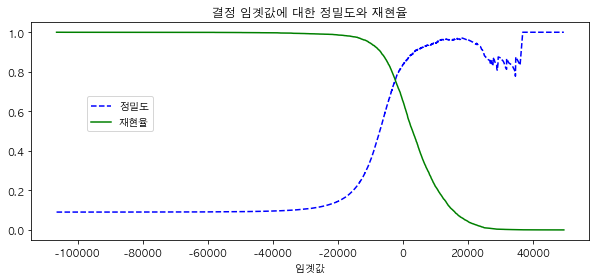

In [21]:
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'AppleGothic'  #한글 출력
matplotlib.rcParams['axes.unicode_minus']=False #마이너스 깨짐 방지
%matplotlib inline

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(10,4))
    plt.plot(thresholds, precisions[:-1], 'b--', label='정밀도')
    plt.plot(thresholds, recalls[:-1], 'g-', label='재현율')
    plt.title('결정 임곗값에 대한 정밀도와 재현율')
    plt.xlabel('임곗값')
    plt.legend(loc=(0.1,0.5))
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

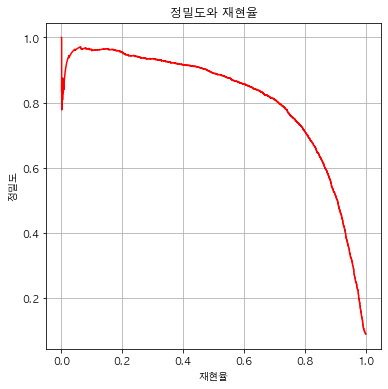

In [22]:
def plot_precision_vs_recall(precisions, recalls):
    plt.figure(figsize=(6,6))
    plt.plot(recalls[:-1], precisions[:-1], 'r-')
    plt.title('정밀도와 재현율')
    plt.xlabel('재현율')
    plt.ylabel('정밀도')
    plt.grid()

plot_precision_vs_recall(precisions, recalls)
plt.show()

In [23]:
threshold_90_precision = thresholds[np.argmax(precisions>=0.90)] 
#정밀도 0.90 이상을 만족하는 임곗값 설정. 이때 np.argmax는 True를 가지는 첫 번째 인덱스 반환

In [24]:
y_train_pred_90 = (y_scores > threshold_90_precision) #예측하는 벡터

In [25]:
precision_score(y_train_5, y_train_pred_90) #정밀도를 0.90 이상으로 설정했으니까

0.9

In [26]:
recall_score(y_train_5, y_train_pred_90) #이때 재현율은 0.47정도

0.47980077476480354

In [27]:
#임곗값 확인
threshold_90_precision

3370.0194991439557

In [28]:
#임곗값을 올리면?
threshold_90_precision = 7000
y_train_pred_90 = (y_scores>threshold_90_precision)

In [29]:
precision_score(y_train_5, y_train_pred_90)

0.9308681672025724

In [30]:
recall_score(y_train_5, y_train_pred_90)

0.32042058660763695

In [31]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

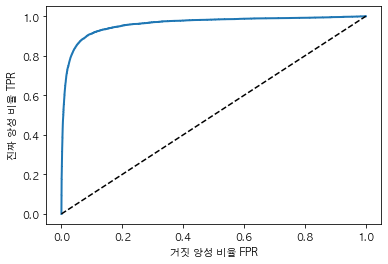

In [32]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr,tpr,linewidth=2,label=label)
    plt.plot([0,1],[0,1],'k--') #대각 점선 그리기
    plt.xlabel('거짓 양성 비율 FPR')
    plt.ylabel('진짜 양성 비율 TPR')

plot_roc_curve(fpr,tpr)
plt.show()

In [33]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [34]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5,
                                   cv=3, method='predict_proba') 
#decision_function 메서드 대신 predict_proba만 존재한다.(확률을 담은 array)

In [35]:
y_probas_forest 
#각각 양성, 음성 클래스로 분류될 확률

array([[0.11, 0.89],
       [0.99, 0.01],
       [0.96, 0.04],
       ...,
       [0.02, 0.98],
       [0.92, 0.08],
       [0.94, 0.06]])

In [36]:
y_scores_forest = y_probas_forest[:,1]
y_scores_forest

array([0.89, 0.01, 0.04, ..., 0.98, 0.08, 0.06])

In [37]:
fpr_forest, tpr_forest, thresholds_forest = roc_curve(
    y_train_5, y_scores_forest)

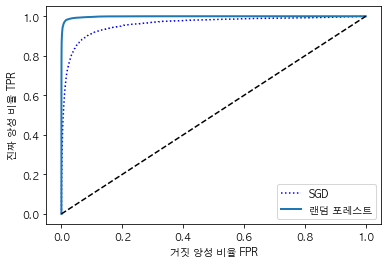

In [38]:
plt.plot(fpr, tpr, 'b:', label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, label='랜덤 포레스트')
plt.legend(loc='lower right')
plt.show()

In [39]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

### 3-3. 다중 분류

In [40]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train) 
#다중 분류이므로 y_train_5가 아닌 y_train
svm_clf.predict(X[0:1])

array(['5'], dtype=object)

In [41]:
some_digit = X[0:1]
some_digit_scores = svm_clf.decision_function(some_digit)
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [42]:
import numpy as np
max_index = np.argmax(some_digit_scores) #최댓값을 만드는 index
svm_clf.classes_[max_index]

'5'

In [47]:
sgd_clf = SGDClassifier()
sgd_clf.fit(X_train, y_train)

SGDClassifier()

In [48]:
sgd_clf.predict(some_digit)

array(['5'], dtype='<U1')

In [49]:
sgd_clf.decision_function(some_digit)

array([[-24119.6778495 , -26640.03639862, -10622.64436882,
         -3787.72508074, -23804.7007578 ,   2898.40846208,
        -29839.58991434, -22933.94095275,  -9869.85355934,
         -8407.09944604]])

In [50]:
cross_val_score(sgd_clf, X_train, y_train,
               cv=3, scoring='accuracy')

array([0.8697 , 0.8687 , 0.87125])

### 3-5. 에러 분석

In [54]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3)

In [56]:
from sklearn.metrics import confusion_matrix
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5425,    1,  159,   44,   22,   59,   82,   11,   84,   36],
       [   2, 6513,   63,   16,   21,   20,    7,   20,   67,   13],
       [  34,   92, 5102,  207,   84,   30,   90,  117,  163,   39],
       [   6,   31,  239, 5221,   20,  201,   34,   79,  189,  111],
       [   9,   29,   60,   13, 5182,   19,   44,   50,   56,  380],
       [  36,   29,   72,  300,  135, 4197,  162,   48,  282,  160],
       [  32,   21,   94,   13,   68,   86, 5546,    5,   43,   10],
       [  14,   27,   60,   24,   86,   11,    5, 5659,   18,  361],
       [  30,  158,  153,  314,  132,  254,   50,   63, 4301,  396],
       [  19,   26,   39,   88,  220,   58,    3,  306,   68, 5122]])

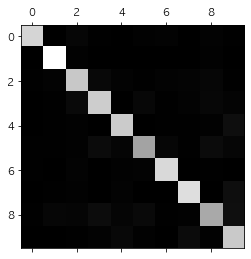

In [57]:
plt.matshow(conf_mx, cmap=plt.cm.gray)

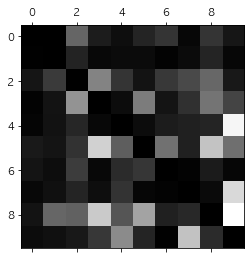

In [67]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx/row_sums
np.fill_diagonal(norm_conf_mx,0) 
#다른 항목은 그대로 유지, 주대각선만 0으로 채우기(not error)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)

### 3-6. 다중 레이블

In [81]:
from sklearn.neighbors import KNeighborsClassifier

y_train = y_train.astype('int') #categorical to int
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [83]:
knn_clf.predict(some_digit)

array([[False,  True]])

In [84]:
y_train_knn_pred = cross_val_predict(knn_clf, 
                    X_train, y_multilabel, cv=3)

In [85]:
f1_score(y_multilabel, y_train_knn_pred, average='macro')
#average = 'weighted' 로 설정하면 가중치가 주어진다.

0.976410265560605

### 3-7. 다중 출력 분류

In [86]:
#잡음 제거 시스템 만들기

#임의로 데이터에 잡음 추가
noise = np.random.randint(0,100,(len(X_train),784))
X_train_mod = X_train+noise #잡음이 섞인 훈련 이미지셋
noise = np.random.randint(0,100,(len(X_test),784))
X_test_mod = X_test+noise #잡음이 섞인 테스트 이미지셋

y_train_mod = X_train #기존 훈련셋은 다중 레이블(훈련용)
y_test_mod = X_test #기존 테스트셋은 다중 레이블(테스트용)


In [87]:
knn_clf.fit(X_train_mod, y_train_mod)

KNeighborsClassifier()

In [121]:
some_index = X_test_mod[0:1]
clean_digit = knn_clf.predict(some_index)
clean_digit_image = clean_digit.reshape(28,28)

(-0.5, 27.5, 27.5, -0.5)

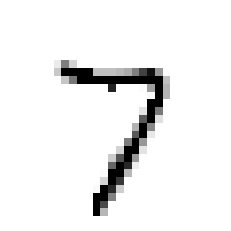

In [122]:
plt.imshow(clean_digit_image, cmap='binary')
plt.axis('off')

(-0.5, 27.5, 27.5, -0.5)

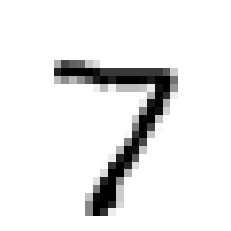

In [126]:
#label 확인
index = y_test_mod[0:1]
label = index.to_numpy() #dataframe을 array로
label_image = label.reshape(28,28) 

plt.imshow(label_image, cmap='binary')
plt.axis('off')